In [1]:
!pip install finance-datareader

In [2]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta

num_images = 5000
day_num = 32

In [3]:
def convert_image(data, num_images, day_num, change_std, save = False, test = False):
    if test:
        change_std = 0

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha))),
            255,
        ]

    # 데이터수가 너무 적으면 패스
    if len(data) <= 100:
        return []


    # 해당 종목의 주가 데이터 - 100이 요구되는 이미지 수보다 적으면(상장직후는 변동이 심할 수있으니 제외)
    if num_images - 100 > len(data):
        num_images = len(data) - 100

    #return_datas는 이미지, 라벨링(상승이면1 하락이면0), 변동률, 날짜를 담고있음
    return_datas = []
    prediction_day_num = 5


    image_idx = 1
    while(image_idx <= num_images):
        prediction_day = data[-image_idx - prediction_day_num : -image_idx]
        predict_mean = prediction_day['Close'].mean()
        now = data.iloc[-image_idx - prediction_day_num - 1]
        change = (predict_mean - now['Close']) / now['Close']


        # change가 너무 높으면 이상치라고 판단하여 패스
        if not test and (abs(change) < change_std or change_std * 2 < abs(change)): # 향후 prediction_day_num일의 변동률이 기준 이하면
            image_idx += 1
            continue

        stock_data = data[-image_idx - day_num - prediction_day_num : -image_idx - prediction_day_num]

        # 이미지 크기 설정
        width, height = 96, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        close_prices = stock_data['Close'].values
        volume_data = stock_data['Volume'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        volume_data_norm = height * (volume_data) / (2 * (np.max(volume_data)))

        # 이동평균선 추가를 위한 stock_data 생성
        stock_data_ma20 = data[-image_idx - day_num - 19: -image_idx]
        stock_data_ma20 = stock_data_ma20.copy()
        stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        stock_data_ma20.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma20['MA20_norm'] = (
                (stock_data_ma20['MA20'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        # 96x96 이미지 생성
        img = np.zeros((height, width, 4), dtype=np.uint8)  # 4 channels for RGBA

        fail_generate = False
        for day in range(32):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(
                (
                    (stock_data['Open'].values[day] - np.min(low_prices))
                    / (np.max(high_prices) - np.min(low_prices))
                )
                * (height - 1)
            )
            volume = int(volume_data_norm[day])
            if(volume == 0):
                fail_generate = True
                break

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0, 255]  # 상승: 빨강
                    tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0, 255]  # 상승: 빨강
                        tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 255 and img[height - 1 - y, x][2] != 255:
                        img[height - 1 - y, x] = tail_color

            # 거래량 그리기
            for x in range(x_start, x_start + 3):
                overlapped = height - volume
                if overlapped >= 0 and overlapped < height:
                    img[overlapped:, x] = [
                        alpha_blend(img[y, x], [128, 128, 128, 255], 0.45)
                        for y in range(overlapped, height)
                    ]

            # 20일 이동평균선 그리기
            ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma20_norm):
                    ma20_y = int(ma20_norm * (height - 1))
                    if 0 <= ma20_y < height:
                        for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([255, 255, 0, 255], img[height - 1 - y, x], 0.6)  # 노란색으로 변경
                                img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += prediction_day_num
            continue

        if save :
            # 이미지 저장
            img = Image.fromarray(img, 'RGBA')
            img.save(f'samsung_stock_data_image_{image_idx}.png')

        if change_std <= change:
            return_datas.append((img, 1))
        elif change <= -change_std :
            return_datas.append((img, 0))

        # 비슷한 이미지를 피하기 위해 기준 예측일만큼 건너뜀
        image_idx += prediction_day_num


    return return_datas

In [4]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [5]:
top_50_tickers = ['005930', '051910', '000660', '207940', '005935', '051915', '006400', '005380', '035420', '363280',
                  '247540', '000270', '086520', '035720', '068270', '012330', '105560', '028260', '055550', '096770',
                  '066570', '047050', '032830', '323410', '003550', '015760', '000810', '033780', '091990', '009150',
                  '086790', '034730', '336370', '352820', '018260', '122630', '017670', '010130', '024880', '003490',
                  '010950', '086280', '259960', '024110', '030200', '316140', '010140', '090430', '028050', '233740']

In [6]:
train_result = []
for i, ticker in enumerate(top_50_tickers):
    print(f"{i+1}번째 종목 추출중...   ")

    data = preprocess_data(fdr.DataReader(ticker))  # 각 종목의 데이터 가져오기
    images = convert_image(data, num_images, day_num, 0.05)
    train_result += images
    print(f"{len(images)}개 추출완료")

train_images, train_labels = zip(*train_result)
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)

1번째 종목 추출중...   
168개 추출완료
2번째 종목 추출중...   
309개 추출완료
3번째 종목 추출중...   
370개 추출완료
4번째 종목 추출중...   
86개 추출완료
5번째 종목 추출중...   
190개 추출완료
6번째 종목 추출중...   
306개 추출완료
7번째 종목 추출중...   
313개 추출완료
8번째 종목 추출중...   
235개 추출완료
9번째 종목 추출중...   
339개 추출완료
10번째 종목 추출중...   
26개 추출완료
11번째 종목 추출중...   
103개 추출완료
12번째 종목 추출중...   
250개 추출완료
13번째 종목 추출중...   
368개 추출완료
14번째 종목 추출중...   
354개 추출완료
15번째 종목 추출중...   
91개 추출완료
16번째 종목 추출중...   
267개 추출완료
17번째 종목 추출중...   
125개 추출완료
18번째 종목 추출중...   
65개 추출완료
19번째 종목 추출중...   
198개 추출완료
20번째 종목 추출중...   
253개 추출완료
21번째 종목 추출중...   
284개 추출완료
22번째 종목 추출중...   
339개 추출완료
23번째 종목 추출중...   
64개 추출완료
24번째 종목 추출중...   
31개 추출완료
25번째 종목 추출중...   
253개 추출완료
26번째 종목 추출중...   
164개 추출완료
27번째 종목 추출중...   
176개 추출완료
28번째 종목 추출중...   
96개 추출완료
29번째 종목 추출중...   
119개 추출완료
30번째 종목 추출중...   
317개 추출완료
31번째 종목 추출중...   
231개 추출완료
32번째 종목 추출중...   
148개 추출완료
33번째 종목 추출중...   
90개 추출완료
34번째 종목 추출중...   
61개 추출완료
35번째 종목 추출중...   
73개 추출완료
36번째 종목 추출중...   
129개 추출완료
37번째 종목 추출중

In [7]:
print(len(train_result))

9977


In [8]:
top_51_60_tickers = [ # 시총 상위 51~60위
    '011170', # 롯데케미칼
    '000100', # 유한양행
    '012450', # 한화에어로스페이스
    '036570', # 엔씨소프트
    '241560', # 두산밥캣
    '005830', # DB손해보험
    '018880', # 한온시스템
    '034220', # LG디스플레이
    '170030', # HD현대
    '161390'  # 한국타이어앤테크놀로지
]

test_result = []
for i, ticker in enumerate(top_51_60_tickers):
    print(f"{i+1}번째 종목 추출중...   ")

    data = preprocess_data(fdr.DataReader(ticker))  # 각 종목의 데이터 가져오기
    images = convert_image(data, num_images, day_num, 0.05, test=True)
    test_result += images
    print(f"{len(images)}개 추출완료")

test_images, test_labels = zip(*test_result)
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)

1번째 종목 추출중...   
990개 추출완료
2번째 종목 추출중...   
988개 추출완료
3번째 종목 추출중...   
994개 추출완료
4번째 종목 추출중...   
994개 추출완료
5번째 종목 추출중...   
286개 추출완료
6번째 종목 추출중...   
993개 추출완료
7번째 종목 추출중...   
985개 추출완료
8번째 종목 추출중...   
919개 추출완료
9번째 종목 추출중...   
296개 추출완료
10번째 종목 추출중...   
509개 추출완료


In [9]:
print(len(test_result))

7954


In [10]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

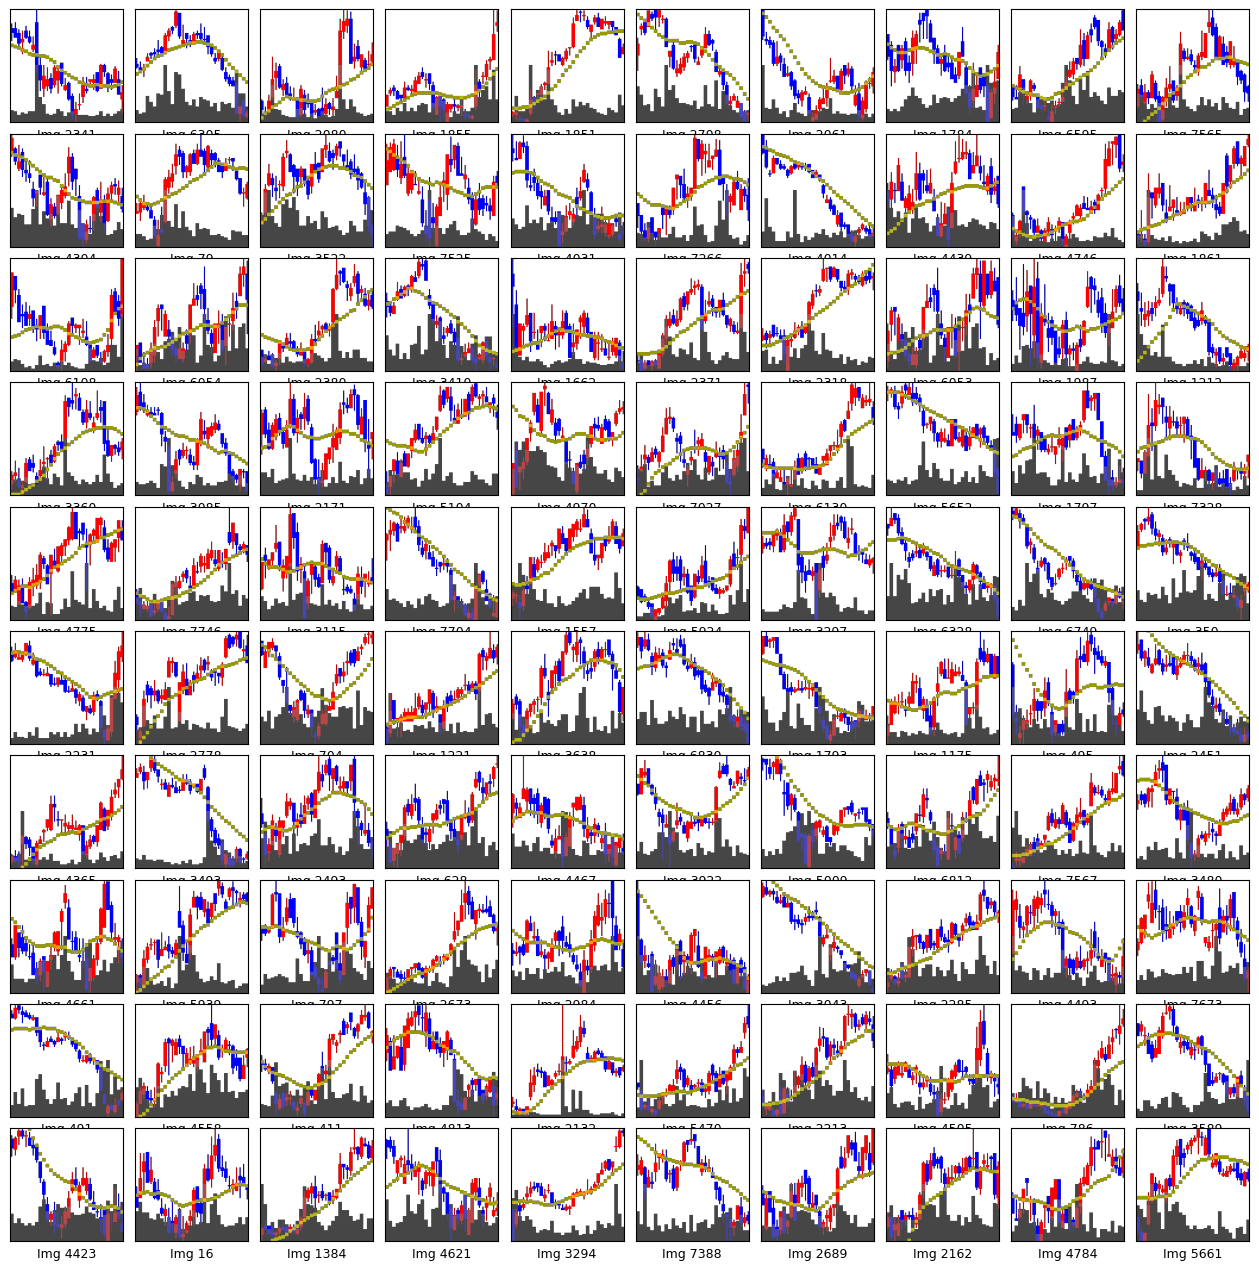

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

images, labels = zip(*test_result)

# 이미지 개수와 그리드 크기 설정
num_images = len(images)
num_to_display = 100
grid_size = int(np.sqrt(num_to_display))

# 랜덤으로 이미지 인덱스 선택
random_indices = np.random.choice(num_images, num_to_display, replace=False)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
for i in range(grid_size):
    for j in range(grid_size):
        img_idx = random_indices[i * grid_size + j]
        img = Image.fromarray(images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel(f'Img {img_idx + 1}', fontsize=9)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

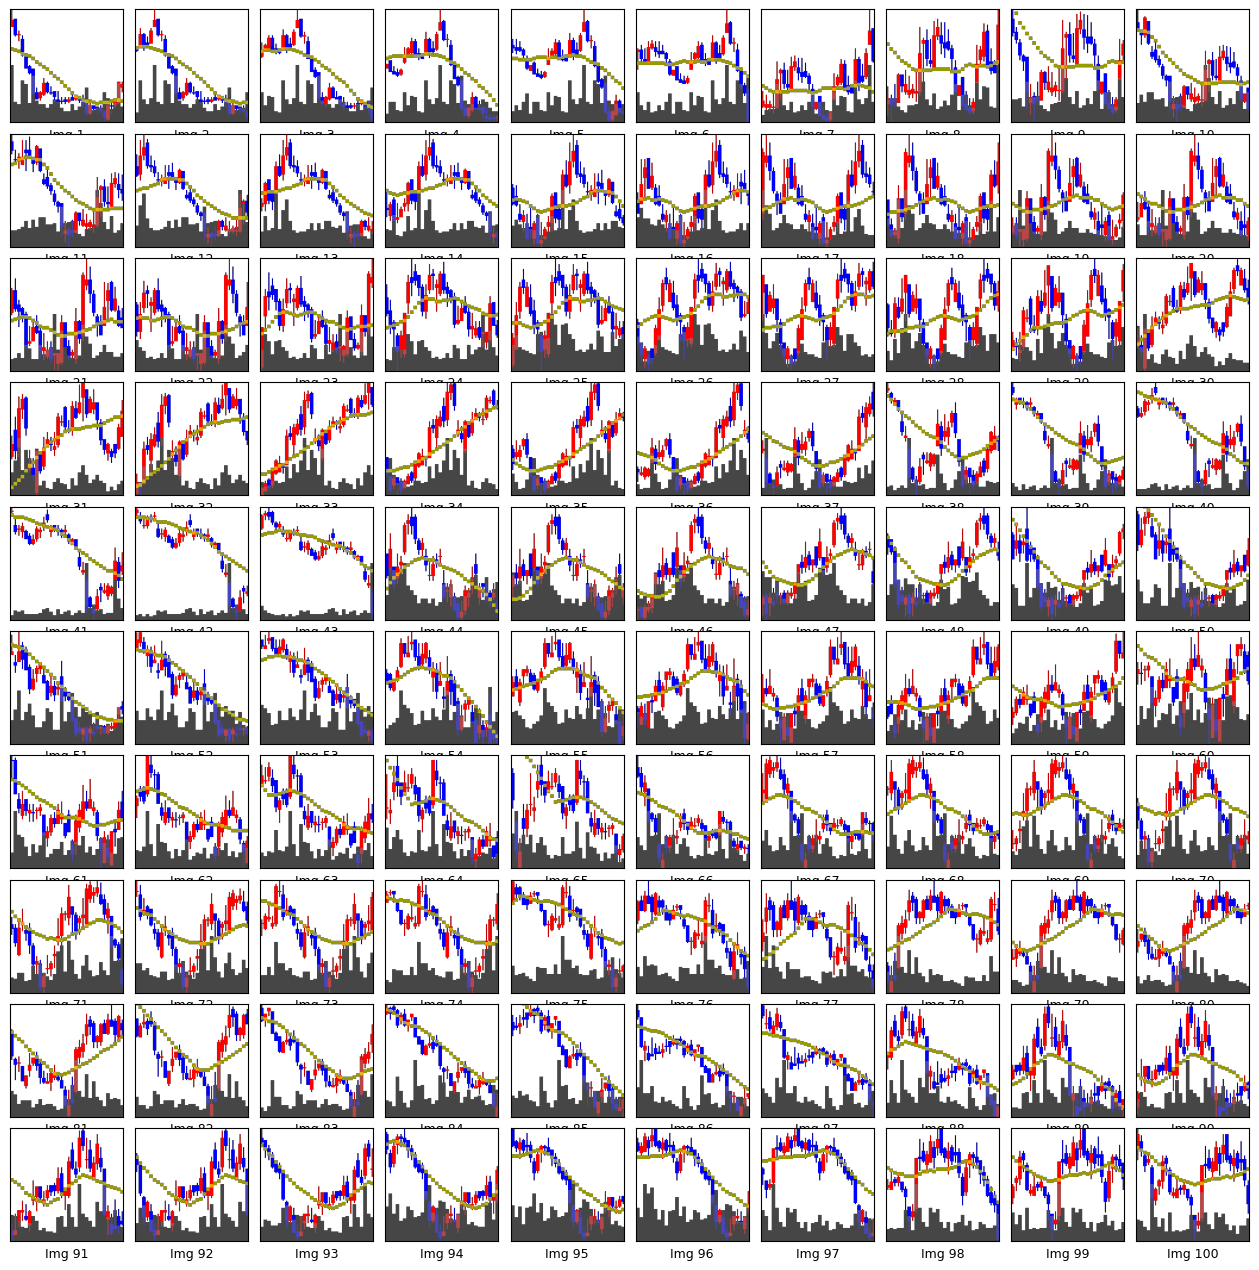

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(16, 16))
for i in range(10):
    for j in range(10):
        img_idx = i * 10 + j
        img = Image.fromarray(test_images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel(f'Img {img_idx + 1}', fontsize=9)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


In [13]:
print(test_labels)

[0 1 1 ... 1 0 1]
